In [1]:
# Author: Samantha Tetef
# Created: 4.19.21
# Title: GP_BUCB_Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import pearsonr

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor

## Testing UCB1, GP-UCG, and  GP-BUCB algorithms

### Creating synthetic data

In [3]:
N = 1000
X = np.linspace(0,1,N)

# parameter space
coeffs = np.linspace(-3,3,21)
print(f"Possible coeffs: {coeffs}")

# all possible actions
Action_Set = np.array(list(itertools.product(coeffs, repeat=3)))
num_permutes = Action_Set.shape[0]
print(f"Actions set shape: {Action_Set.shape}")

Possible coeffs: [-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7  3. ]
Actions set shape: (9261, 3)


In [4]:
def add_noise_to_output(Y, sig=0.1):
    """Add random gaussian noise to output."""
    noise = np.random.normal(loc=0.0, scale=sig, size=Y.shape)
    return Y + noise 

def add_systematic_low_to_actions(actions_tuple, err_percent=0.05):
    """Takes aech action and makes the result actually lower."""
    a, b, c = actions_tuple
    return [action*(1 - err_percent) for action in actions_tuple]

def add_systematic_high_to_actions(actions_tuple, err_percent=0.05):
    """Takes aech action and makes the result actually higher."""
    return [action*(1 + err_percent) for action in actions_tuple]

def add_randomness_to_actions(actions_tuple, sig=0.1):
    """Takes aech action and makes the result actually random."""
    noise = np.random.normal(loc=0.0, scale=sig, size=len(actions_tuple))
    return actions_tuple + noise

def get_output(actions, X):
    """Transforms actions and input into output."""
    return actions[0]*X**2 + actions[1]*X + actions[2]

### Generating data with a systematic error such that the real cooefficients are actually less than reported.

In [5]:
num_repeats = 5
Y = np.zeros((num_permutes*num_repeats,N))
# targets are polynomial using actions as coeffs
for i in range(num_permutes):
    actions = Action_Set[i]
    for j in range(num_repeats):
        # systematic low to coeffs
        low_actions = add_systematic_low_to_actions(actions)
        Y[i + num_permutes*j] = add_noise_to_output(get_output(low_actions, X))

print(Y.shape)

(46305, 1000)


In [6]:
Dataset = np.tile(Action_Set, (num_repeats,1))
Dataset.shape

(46305, 3)

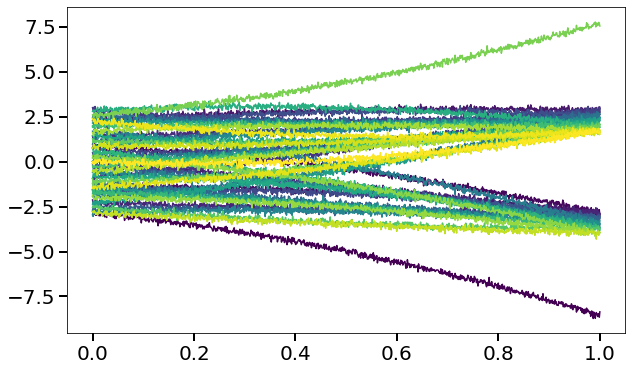

In [7]:
# displaying data
fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

Colors = plt.cm.viridis(np.arange(num_permutes*num_repeats)/(num_permutes*num_repeats-1))

for i in range(len(Y)):
    if not i % 1000:
        plt.plot(X, Y[i], '-', c=Colors[i])

plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.show()

### Creating "target" spectra

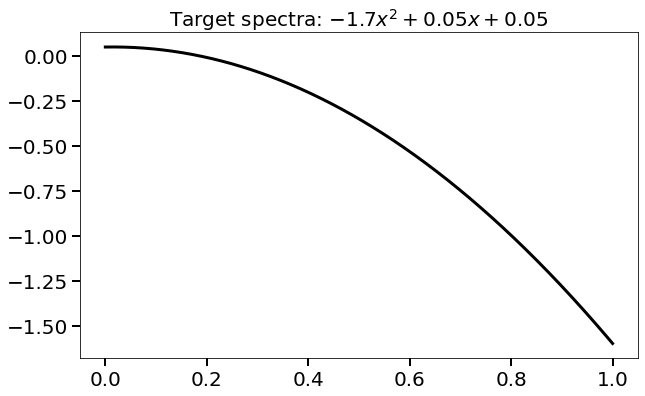

In [8]:
# create wanted "target"
target_action = (-1.7, 0.05, 0.05)
target = target_action[0]*X**2 + target_action[1]*X + target_action[2]

fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

plt.plot(X, target, 'k-', linewidth=3)

plt.title(f"Target spectra: ${target_action[0]}x^2 + {target_action[1]}x + {target_action[2]}$", fontsize=20)
plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.show()

### Defining a metric (MSE is an error metric, se we want to minimize this)

In [9]:
def MSE(Y, target):
    return np.sum((Y-target)**2, axis=1)/Y.shape[0]

In [10]:
Pearsons = []
for y in Y:
    Pearsons.append(np.round(pearsonr(y, target)[0], 5))

In [11]:
mse = np.round(MSE(Y, target), 5)

In [12]:
# create dataframe
columns = ['a', 'b', 'c']
df = pd.DataFrame(data=Dataset, columns=columns)
df['MSE'] = mse
df['Pearsons'] = Pearsons
df

,a,b,c,MSE,Pearsons
0,-3.0,-3.0,-3.0,0.51395,0.98963
1,-3.0,-3.0,-2.7,0.45827,0.98943
2,-3.0,-3.0,-2.4,0.40458,0.98910
3,-3.0,-3.0,-2.1,0.35438,0.98967
4,-3.0,-3.0,-1.8,0.30933,0.98938
...,...,...,...,...,...
46300,3.0,3.0,1.8,0.55330,-0.98981
46301,3.0,3.0,2.1,0.61147,-0.99005
46302,3.0,3.0,2.4,0.67257,-0.98979
46303,3.0,3.0,2.7,0.73775,-0.98970


# UCB1

In [13]:
def ucb1_policy(df, time_step, column_names, batch_size=3, ucb_scale=2.0):
    '''
    Applies UCB1 policy to generate recommendations.
    
    This is adapted from the tutorial found at
    https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/
    
    Arguments:
        df - dataset on which to apply UCB policy
            type == dataframe
        time_step - current time step (start at 1)
            type == int
        column_names - list of action names, i.e., df column names
            type == list
        batch_size - the number of recommendations to give
            default = 3
            type == int
        ucb_scale - the scale of the upper bound
            default = 2.0
            type == float
    Returns:
        actions - a subset of the data with the highest ucb
            type == dataframe        
    '''
    grouped_df = df.groupby(column_names)
    grouped_df = grouped_df.agg(['mean', 'count', 'std'])
    
    grouped_df['ucb'] = grouped_df[('MSE', 'mean')] + \
        np.sqrt(2*np.log(time_step) / grouped_df[('MSE', 'count')])
        # Gaussian
#         2 * grouped_df[('MSE', 'mean')] / np.sqrt(grouped_df[('MSE', 'mean')])
    
    # flip the MSE
    grouped_df['ucb'] = -grouped_df['ucb']
    
    scores = grouped_df.sort_values('ucb', ascending=False)

    recs = scores.index[:batch_size].values
    return recs

### Implement the UCB1 policy

In [14]:
# Get recomendations for 5 time steps
Recomendations = []
total_time_steps = 5
for t in range(total_time_steps):
    recs = ucb1_policy(df, t + 1, columns, batch_size=1)
    Recomendations.append(recs)

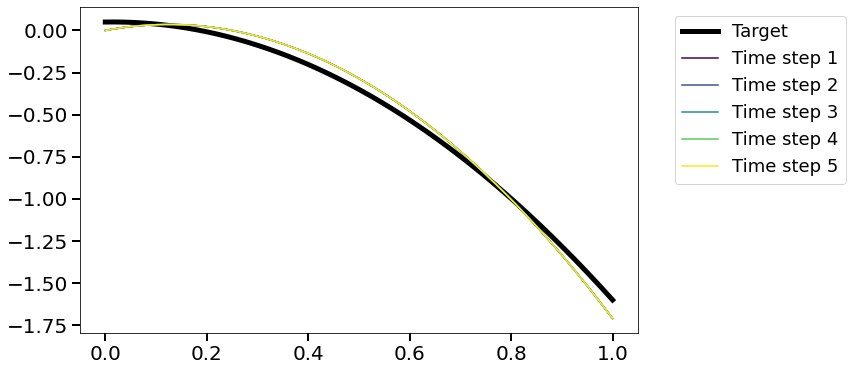

In [33]:
# displaying data
def plot_result_of_action_set(Recomendations, cm=plt.cm.viridis, ncols=1):
    total_time_steps = len(Recomendations)
    
    fig, ax = plt.subplots(figsize=(10,6))
    fontsize = 16

    Colors = cm(np.arange(total_time_steps)/(total_time_steps-1))

    plt.plot(X, target, 'k-', linewidth=5, label="Target")

    for t in range(total_time_steps):
        i = 0
        if type(Recomendations[t][0]) is tuple:
            action =  Recomendations[t][0]
        else:
            action = Recomendations[t]
        low_action = add_systematic_low_to_actions(action)
        if i == 0:
            plt.plot(X, get_output(low_action, X), '-', c=Colors[t], label=f"Time step {t+1}")
        else:
            plt.plot(X, get_output(low_action, X), '-', c=Colors[t])
        i += 1

    plt.xticks(fontsize=fontsize+4)
    plt.yticks(fontsize=fontsize+4)

    ax.tick_params(direction='out', width=2, length=8)
    ax.tick_params(direction='out', which='minor', width=1, length=5)

    plt.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=ncols)
    plt.show()
    
    
plot_result_of_action_set(Recomendations)

### The UCB1 algorithm seems to be able to pick up systematic low errors. However, the time step does not seem to affect the recommendations...

# GP-UCB

In [16]:
# from https://github.com/tushuhei/gpucb

In [17]:
import ucb

In [18]:
x = np.arange(-3, 3, 0.25)
y = np.arange(-3, 3, 0.25)
grid = np.meshgrid(x, y)

In [19]:
  class DummyEnvironment(object):
    def sample(self, x):
        return np.sin(x[0]) + np.cos(x[1])

In [20]:
np.array(grid).shape

(2, 24, 24)

In [21]:
env = DummyEnvironment()
agent = ucb.GPUCB(grid, env)

In [22]:
agent.X_grid.shape

(576, 2)

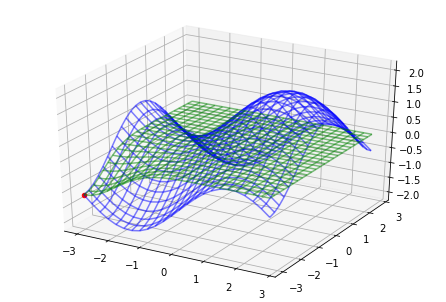

In [23]:
for i in range(20):
    agent.learn()
    break
agent.plot()

In [24]:
# modifying it to work with this toy example

In [25]:
class Environment(object):
    def __init__(self, X_arr, target):
        # in future this will be basis spectra
        self.X_arr = X_arr
        self.target = target
    
    def sample(self, action):
        # add systematic low here
        # get output was defined above
        result = get_output(action, self.X_arr)
        return pearsonr(result, self.target)[0]

In [26]:
coeffs = np.linspace(-3,3,21)
param_space = np.meshgrid(coeffs, coeffs, coeffs)
print(np.array(param_space).shape)

(3, 21, 21, 21)


In [27]:
env = Environment(X, target)
ps = np.array(param_space)
agent = ucb.GPUCB(ps, env)

In [28]:
# training loop
for i in range(20):
    agent.learn()

In [29]:
agent.X

[array([-3., -3., -3.]),
 array([-2.7, -2.7, -0.9]),
 array([-1.2, -2.1, -2.4]),
 array([-3. , -0.9, -2.1]),
 array([-1.5, -0.9, -0.6]),
 array([-1.2,  0.3, -2.4]),
 array([-2.7,  0.9, -0.9]),
 array([-0.6,  1.2, -0.6]),
 array([-3. ,  1.2, -3. ]),
 array([-0.6, -3. , -0.3]),
 array([-2.1, -2.1,  1.2]),
 array([-3. , -0.3,  0.9]),
 array([ 0. , -1.5,  1.2]),
 array([ 0.6, -1.5, -1.2]),
 array([-1.5, -0.3,  2.4]),
 array([-0.9, -2.4,  3. ]),
 array([-3. , -1.5,  3. ]),
 array([ 1.5, -3. ,  0.3]),
 array([ 1.2, -3. ,  2.4]),
 array([ 0.9, -0.9,  3. ])]

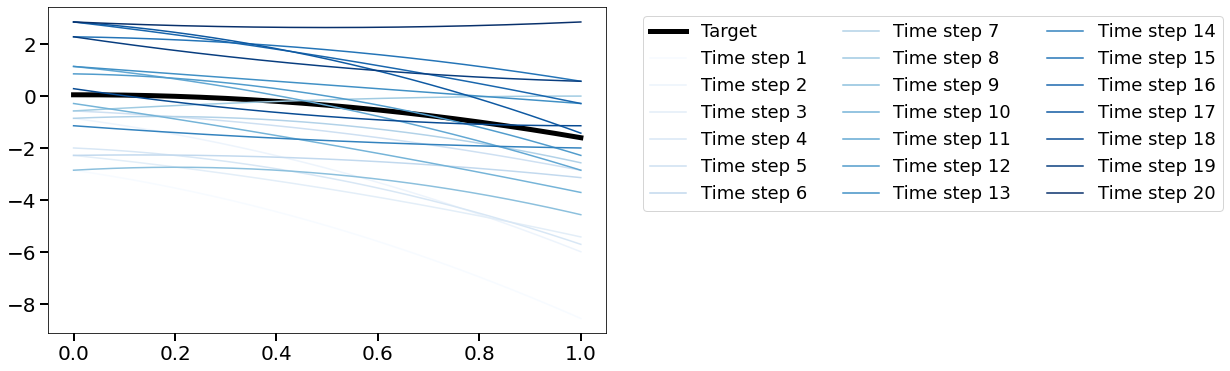

In [35]:
plot_result_of_action_set(agent.X, cm=plt.cm.Blues, ncols=3)